In [1]:
import torch
import os
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))

True
Tesla P100-PCIE-16GB


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        out = self.generator(x)

        return out

generator = Generator().to(device)

# Initialize the lazy modules by passing a dummy input
dummy_input = torch.zeros(1, 3, 32, 32).to(device)
generator(dummy_input)

generator_model_path = './models/generator_epoch_100.pt' 

# Load the model state dict
generator.load_state_dict(torch.load(generator_model_path))
generator.eval()

/tmp/ipykernel_131628/4285734626.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_model_path))


Generator(
  (generator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (4): PReLU(num_parameters=1)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (7): PReLU(num_parameters=1)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (10): PReLU(num_parameters=1)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (13): PReLU(num_parameters=1)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [5]:
# Define the mean and std used during normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [6]:
test_input = torch.rand(1,3,32,32).to(device)
print(generator(test_input).shape)

torch.Size([1, 3, 128, 128])


In [7]:

# Define the main directory for the dataset
main_dir = './Data/train'

# Define where to save the new dataset
output_dir = './Data/srgan-images/train'

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Define transformations for the low-resolution images (include normalization)
lr_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Populate the lists with image paths and corresponding labels
for image_name in os.listdir(main_dir):
    if image_name.startswith("cat"):
        label = 0  # Label for cat
    elif image_name.startswith("dog"):
        label = 1  # Label for dog
    else:
        continue
    image_path = os.path.join(main_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to unnormalize and save image tensors as images
def save_tensor_as_image(tensor, filename):
    tensor = tensor.cpu().detach()
    # Unnormalize the tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor = torch.clamp(tensor, 0, 1)
    array = tensor.mul(255).permute(1, 2, 0).byte().numpy()
    image = Image.fromarray(array)
    image.save(filename)

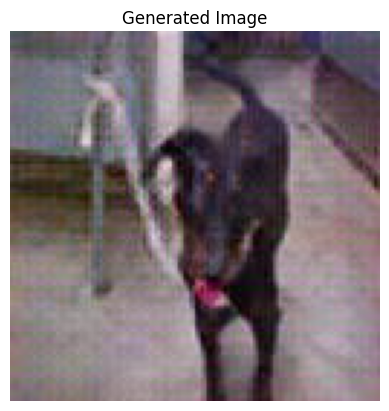

In [8]:
# Test with a single image
image_path = image_paths[0]
image = Image.open(image_path).convert('RGB')
lr_image = lr_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    sr_image = generator(lr_image)

# Save the generated image
output_path = './srgan-test-image.jpeg'
save_tensor_as_image(sr_image.squeeze(0), output_path)

# Display the image
img = Image.open(output_path)
plt.imshow(img)
plt.title('Generated Image')
plt.axis('off')
plt.show()


In [9]:
from tqdm import tqdm

# Loop over the dataset and generate images
with torch.no_grad():
    for idx, (image_path, label) in tqdm(enumerate(zip(image_paths, labels)), total=len(image_paths), desc="Generating Images"):
        # Load and preprocess the low-resolution image
        image = Image.open(image_path).convert('RGB')
        lr_image = lr_transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Generate high-resolution image
        sr_image = generator(lr_image)

        # Unnormalize the generated image and save it
        # (Already handled in the save_tensor_as_image function)

        # Create a filename (using the same filename as the original image)
        filename = os.path.basename(image_path)

        output_path = os.path.join(output_dir, filename)

        # Save the generated image
        save_tensor_as_image(sr_image.squeeze(0), output_path)  # Remove batch dimension

# Verify the new dataset
print(f"Generated images are saved in '{output_dir}' directory.")


Generating Images: 100%|██████████| 25000/25000 [10:28<00:00, 39.80it/s]

Generated images are saved in './Data/srgan-images/train' directory.


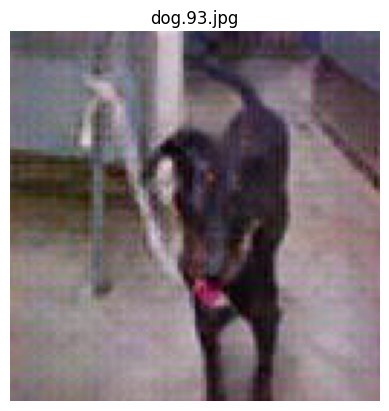

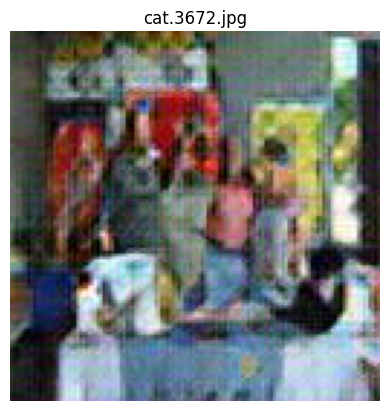

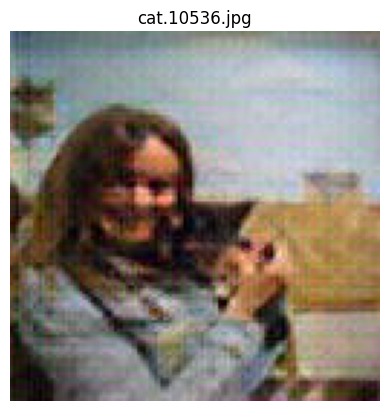

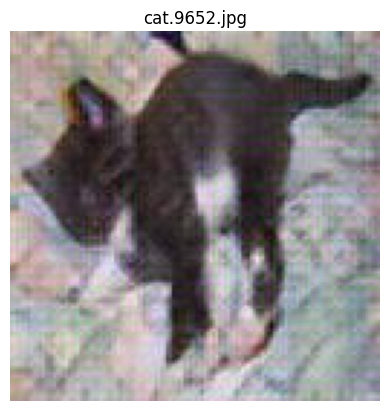

In [10]:
# Display some generated images
generated_image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir)]
for img_path in generated_image_paths[:4]:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')  # Hide axis for better visualization
    plt.show()
